In [85]:
# urn and other imports
import unityneuro.render as urn
import numpy as np
import pandas as pd
# ibl imports
from one.api import ONE
one = ONE(base_url='https://alyx.internationalbrainlab.org')
from brainbox.io.one import SpikeSortingLoader
import ibllib.atlas as atlas
CCFAtlas = atlas.AllenAtlas(25)
NeedlesAtlas = atlas.NeedlesAtlas(25)
MRITorontoAtlas = atlas.MRITorontoAtlas(25)

import matplotlib.pyplot as plt

In [86]:
def get_bwm_sessions():

    '''
    Gaelle, 06.04.2022
    '''

    str_query = (  
       'session__project__name__icontains,ibl_neuropixel_brainwide_01,'
       'session__json__IS_MOCK,False,session__qc__lt'
       ',50,~json__qc,CRITICAL,'
       'session__extended_qc__behavior,1,'
       'json__extended_qc__tracing_exists,True,'
       '~session__extended_qc___task_stimOn_goCue_delays__lt,0.9,'
       '~session__extended_qc___task_response_feedback_delays__lt,0.9,'
       '~session__extended_qc___task_wheel_move_before_feedback__lt,0.9,'
       '~session__extended_qc___task_wheel_freeze_during_quiescence__lt,0.9,'
       '~session__extended_qc___task_error_trial_event_sequence__lt,0.9,'
       '~session__extended_qc___task_correct_trial_event_sequence__lt,0.9,'
       '~session__extended_qc___task_reward_volumes__lt,0.9,'
       '~session__extended_qc___task_reward_volume_set__lt,0.9,'
       '~session__extended_qc___task_stimulus_move_before_goCue__lt,0.9,'
       '~session__extended_qc___task_audio_pre_trial__lt,0.9')                  
        
    str_query2 = (
       'session__project__name__icontains,ibl_neuropixel_brainwide_01,'
       'session__json__IS_MOCK,False,session__qc__lt,50,'
       '~json__qc,CRITICAL,session__extended_qc__behavior,1,'       
       'json__extended_qc__tracing_exists,True,'
       'session__extended_qc___experimenter_task,PASS')        
            
    ins = np.concatenate([one.alyx.rest('insertions', 'list', django = x)
                          for x in [str_query, str_query2]])

    eid_probe = set([x['session']+'_'+x['name'] for x in ins]) # pid via x['id']
    ins = [x.split('_') for x in eid_probe] 
 
    return ins

In [87]:
ins = get_bwm_sessions()

# Collect insertion data (planned/micro-manip/histology)

In [88]:
def vec_dist(coord0, coord1):
    return np.sqrt(np.sum(np.power([coord0[0]-coord1[0],coord0[1]-coord1[1],coord0[2]-coord1[2]],2)))
def vec_dist_apml(coord0, coord1):
    return np.sqrt(np.sum(np.power([coord0[0]-coord1[0],coord0[1]-coord1[1]],2)))

def getCoords(ins, coord_transform):
    entry_coords = coord_transform.xyz2ccf(ins.entry)
    tip_coords = coord_transform.xyz2ccf(ins.tip)
    angles = [ins.phi, ins.theta, ins.beta]
    depth = vec_dist(entry_coords, tip_coords)
    return (entry_coords, tip_coords, angles, depth)

def traj2coords(traj, coord_transform):
    insertion = atlas.Insertion.from_dict(traj)
    return getCoords(insertion, coord_transform)


In [89]:
prov_planned = 'planned'
prov_mm = 'Micro-manipulator'
prov_ephys = 'Ephys aligned histology track'

bwm_planned = one.alyx.rest('trajectories', 'list', provenance=prov_planned,
                          project='ibl_neuropixel_brainwide_01', use_cache=False)
bwm_mm = one.alyx.rest('trajectories', 'list', provenance=prov_mm,
                          project='ibl_neuropixel_brainwide_01', use_cache=False)
bwm_ephys = one.alyx.rest('trajectories', 'list', provenance=prov_ephys,
                          project='ibl_neuropixel_brainwide_01', use_cache=False)

In [90]:
traj_data = pd.DataFrame(columns=['pid','lab',
                                  'ml_e_p','ap_e_p','dv_e_p',
                                  'ml_t_p','ap_t_p','dv_t_p',
                                  'phi_p','theta_p','depth_p',
                                  'ml_e_m','ap_e_m','dv_e_m',
                                  'ml_t_m','ap_t_m','dv_t_m',
                                  'phi_m','theta_m','depth_m',
                                  'ml_e_e','ap_e_e','dv_e_e',
                                  'ml_t_e','ap_t_e','dv_t_e',
                                  'phi_e','theta_e','depth_e'])
mri_data = pd.DataFrame(columns=['pid','ml_e_m','ap_e_m','dv_e_m',
                                 'ml_t_m','ap_t_m','dv_t_m'])

In [91]:
# re-organize data into a dictionary
data = {}
for (eid,probe) in ins:
    if not eid in data.keys():
        data[eid] = {}
    data[eid][probe] = {}
    
for traj in bwm_planned:
    eid = traj['session']['id']
    probe_name = traj['probe_name']
    
    if eid in data.keys() and probe_name in data[eid].keys():
        data[eid][probe_name]['planned'] = traj
        
for traj in bwm_mm:
    eid = traj['session']['id']
    probe_name = traj['probe_name']
    
    if eid in data.keys() and probe_name in data[eid].keys():
        data[eid][probe_name]['micro-manip'] = traj
        
for traj in bwm_ephys:
    eid = traj['session']['id']
    probe_name = traj['probe_name']
    
    if eid in data.keys() and probe_name in data[eid].keys():
        data[eid][probe_name]['ephys'] = traj

In [92]:
count = 0

for eid in data.keys():
    for probe_name in data[eid].keys():
        # print((eid,probe_name))
        
        
        tdata = data[eid][probe_name]
        missing = False
        
        if 'planned' in tdata.keys():
            (ecoords_p, tcoords_p, angles_p, depth_p) = traj2coords(tdata['planned'], NeedlesAtlas)
        else:
            print(f"{eid} {probe_name} missing planned")
            missing = True

        if 'micro-manip' in tdata.keys():
            (ecoords_m, tcoords_m, angles_m, depth_m) = traj2coords(tdata['micro-manip'], NeedlesAtlas)
            # also compute the micro-manip -> CCF using the MRI-linear transform
            # we'll do this by hand
            (ecoords_m_mri, tcoords_m_mri, angles_m_mri, depth_m_mri) = traj2coords(tdata['micro-manip'], MRITorontoAtlas)
        else:
            print(f"{eid} {probe_name} missing micro-manip")
            missing = True

        if 'ephys' in tdata.keys():
            (ecoords_e, tcoords_e, angles_e, depth_e) = traj2coords(tdata['ephys'], CCFAtlas)
        else:
            print(f"{eid} {probe_name} missing ephys")
            missing = True

        if missing:
            continue

        traj_data.loc[count] = [tdata['planned']['probe_insertion'],tdata['planned']['session']['lab'],
                            ecoords_p[0],ecoords_p[1],ecoords_p[2],
                            tcoords_p[0],tcoords_p[1],tcoords_p[2],
                            angles_p[0],angles_p[1],depth_p,
                            ecoords_m[0],ecoords_m[1],ecoords_m[2],
                            tcoords_m[0],tcoords_m[1],tcoords_m[2],
                            angles_m[0],angles_m[1],depth_m,
                            ecoords_e[0],ecoords_e[1],ecoords_e[2],
                            tcoords_e[0],tcoords_e[1],tcoords_e[2],
                            angles_e[0],angles_e[1],depth_e]
        mri_data.loc[count] = [tdata['planned']['probe_insertion'],
                               ecoords_m_mri[0], ecoords_m_mri[1], ecoords_m_mri[2],
                               tcoords_m_mri[0], tcoords_m_mri[1], tcoords_m_mri[2]]
        
        count+=1

traj_data.to_csv('bwm_all_traj.csv',float_format='%.03f')
mri_data.to_csv('bwm_mri_coords.csv',float_format='%.03f')

549caacc-3bd7-40f1-913d-e94141816547 probe01 missing planned
6fb1e12c-883b-46d1-a745-473cde3232c8 probe01 missing planned
1211f4af-d3e4-4c4e-9d0b-75a0bc2bf1f0 probe01 missing planned
09394481-8dd2-4d5c-9327-f2753ede92d7 probe00 missing planned
09394481-8dd2-4d5c-9327-f2753ede92d7 probe01 missing planned
09b2c4d1-058d-4c84-9fd4-97530f85baf6 probe01 missing planned
5285c561-80da-4563-8694-739da92e5dd0 probe01 missing planned
8c2f7f4d-7346-42a4-a715-4d37a5208535 probe01 missing planned
6ed57216-498d-48a6-b48b-a243a34710ea probe00 missing planned
6ed57216-498d-48a6-b48b-a243a34710ea probe01 missing planned
37e96d0b-5b4b-4c6e-9b29-7edbdc94bbd0 probe01 missing planned
258b4a8b-28e3-4c18-9f86-1ea2bc0dc806 probe01 missing planned
258b4a8b-28e3-4c18-9f86-1ea2bc0dc806 probe01 missing micro-manip
258b4a8b-28e3-4c18-9f86-1ea2bc0dc806 probe01 missing ephys
258b4a8b-28e3-4c18-9f86-1ea2bc0dc806 probe00 missing planned
258b4a8b-28e3-4c18-9f86-1ea2bc0dc806 probe00 missing micro-manip
258b4a8b-28e3-4c18

In [93]:
traj_data

,pid,lab,ml_e_p,ap_e_p,dv_e_p,ml_t_p,ap_t_p,dv_t_p,phi_p,theta_p,...,depth_m,ml_e_e,ap_e_e,dv_e_e,ml_t_e,ap_t_e,dv_t_e,phi_e,theta_e,depth_e
0,8dfb86c8-d45c-46c4-90ec-33078014d434,angelakilab,4935.0,6089.972401,332.000000,3827.124626,6089.972401,6931.867084,0.0,10.0,...,6692.206914,4675.0,5925.0,525.0,4401.221324,7186.911353,6718.068479,77.759068,11.777565,6326.252620
1,362823e7-5514-41d3-a31d-4b73f91ad3d0,zadorlab,6739.0,7929.898804,235.361345,4927.464918,7929.898804,6459.378433,0.0,17.0,...,5717.511274,6525.0,8775.0,250.0,5029.273706,9412.200367,6784.342317,23.074684,13.971963,6733.561537
2,57656bee-e32e-4848-b924-0f6f18cfdfb1,zadorlab,3496.0,7239.926403,509.521008,4531.276180,7239.926403,4568.032884,180.0,15.0,...,4084.181109,3625.0,7650.0,375.0,4639.760284,8379.857455,3977.570488,144.274754,19.135073,3813.259034
3,e42e948c-3154-45cb-bf52-408b7cda0f2f,churchlandlab_ucla,3496.0,7239.926403,509.521008,4531.276180,7239.926403,4568.032884,180.0,15.0,...,5370.252086,3525.0,8050.0,425.0,4164.419198,8637.391136,4669.309954,137.428414,11.561574,4332.211011
4,99086aba-f671-42b5-bdc0-e665c61f5452,zadorlab,4445.0,7699.908004,260.571429,5480.276180,7699.908004,4319.083304,180.0,15.0,...,4186.798725,4300.0,7775.0,225.0,5240.989654,8674.384829,3874.884733,136.295049,19.627973,3875.050086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,e8f9fba4-d151-4b00-bee7-447f0f3e752c,mainenlab,4426.0,6549.954002,410.781513,3242.587669,6549.954002,7460.639534,0.0,10.0,...,7148.493749,4300.0,6825.0,325.0,2986.222025,7105.292009,7193.793610,12.043383,11.065790,6998.921477
530,9b3ad89a-177f-4242-9a96-2fd98721e47f,hoferlab,2859.0,7469.917203,710.151261,1784.812373,7469.917203,7109.332731,0.0,10.0,...,5611.803603,2725.0,7875.0,700.0,1542.361217,8272.179112,5887.647942,18.564185,13.522009,5335.548417
531,8aba5f8c-4438-4588-9bb0-b20d2fd3eca5,wittenlab,4939.0,3100.091996,1485.361345,5974.276180,3100.091996,5543.873220,180.0,15.0,...,4188.474115,4750.0,2400.0,1825.0,5477.796003,3524.730610,4630.006473,122.906289,25.529062,3108.499201
532,c16b8e98-100f-40ce-b417-b1524c7e1270,danlab,2162.0,8619.871205,1160.781513,3197.276180,8619.871205,5219.293388,180.0,15.0,...,4188.474115,2050.0,8950.0,1250.0,3163.674464,8982.307524,5388.921030,178.338324,15.066140,4286.254995


In [94]:
mri_data

,pid,ml_e_m,ap_e_m,dv_e_m,ml_t_m,ap_t_m,dv_t_m
0,8dfb86c8-d45c-46c4-90ec-33078014d434,4894.462185,6127.449079,332.000000,3730.727549,6127.449079,7431.518039
1,362823e7-5514-41d3-a31d-4b73f91ad3d0,6790.995798,8070.223084,1961.604520,5112.622514,8070.223084,7866.921459
2,57656bee-e32e-4848-b924-0f6f18cfdfb1,3236.584034,7101.163919,1184.203390,4296.980886,7101.163919,5441.262252
3,e42e948c-3154-45cb-bf52-408b7cda0f2f,3351.394958,7366.440349,493.581921,4745.701003,7366.440349,6091.149370
4,99086aba-f671-42b5-bdc0-e665c61f5452,4376.500000,7734.432590,992.903955,5463.539989,7734.432590,5356.924095
...,...,...,...,...,...,...,...
529,e8f9fba4-d151-4b00-bee7-447f0f3e752c,4355.596639,6615.324927,619.005650,3112.516459,6615.324927,8202.581736
530,9b3ad89a-177f-4242-9a96-2fd98721e47f,2719.042017,7582.347236,738.779661,1743.183035,7582.347236,6692.137264
531,8aba5f8c-4438-4588-9bb0-b20d2fd3eca5,4720.302521,3297.769156,1182.960452,5807.777500,3297.769156,5548.726898
532,c16b8e98-100f-40ce-b417-b1524c7e1270,1981.647059,8794.762367,1223.525424,3069.122038,8794.762367,5589.291870


# Discrepancy 1: Planned identical to micro-manipulator
Analyze the *surface* coordinate and check whether it is identical from planned to micro-manipulator, suggesting the researcher did not enter the real micro-manipulator coordinates

In [95]:
def disc1(row):
    planned = (row['ml_e_p'], row['ap_e_p'], row['dv_e_p'])
    micro = (row['ml_e_m'], row['ap_e_m'], row['dv_e_m'])
    return planned[0]==micro[0] and planned[1]==micro[1] and planned[2]==micro[2]

In [96]:
p_identical_mm = []
for i, row in traj_data.iterrows():
    p_identical_mm.append(disc1(row))

traj_data['p_identical_mm'] = p_identical_mm

traj_data.to_csv('bwm_all_traj_discrep.csv',float_format='%.03f')

In [97]:
print(np.sum(traj_data['p_identical_mm']))

82


# Discrepancy 2: >1mm distance from micro-manipulator to ephys
Analyze the surface coordinate to check whether the micro-manipulator coordinate is >1mm away from the ephys coordinate
we'll use only ap/ml and ignore dv for this

In [98]:
def disc2(row):
    micro = (row['ml_e_m'], row['ap_e_m'], row['dv_e_m'])
    ephys = (row['ml_e_e'], row['ap_e_e'], row['dv_e_e'])
    return np.hypot(micro[0]-ephys[0],micro[1]-ephys[1]) > 1000

In [99]:
mm_ephys_dist = []
for i, row in traj_data.iterrows():
    mm_ephys_dist.append(disc2(row))

traj_data['mm_ephys_dist'] = mm_ephys_dist

traj_data.to_csv('bwm_all_traj_discrep.csv',float_format='%.03f')

In [100]:
print(np.sum(traj_data['mm_ephys_dist']))

45


# Discrepancy 3: Flipped DV axis
Check whether the DV coordinate for micro-manipulator and ephys are flipped relative to zero (suggesting the researcher doesn't know which way is which)

In [101]:
def disc3(row):
    micro = (row['ml_e_m'], row['ap_e_m'], row['dv_e_m'])
    ephys = (row['ml_e_e'], row['ap_e_e'], row['dv_e_e'])
    return (micro[2] > 0 and ephys[2] < 0) or (micro[2] < 0 and ephys[2] > 0)

In [102]:
flipz = []
for i, row in traj_data.iterrows():
    flipz.append(disc3(row))

traj_data['flipz'] = flipz

traj_data.to_csv('bwm_all_traj_discrep.csv',float_format='%.03f')

In [103]:
print(np.sum(traj_data['flipz']))

60


# Discrepancy 4: 0 in micro-manipulator DV position

In [104]:
def disc4(row):
    micro = (row['ml_e_m'], row['ap_e_m'], row['dv_e_m'])
    return micro[2]==0

In [105]:
mm_zero_dv = []
for i, row in traj_data.iterrows():
    mm_zero_dv.append(disc4(row))

traj_data['mm_zero_dv'] = mm_zero_dv

traj_data.to_csv('bwm_all_traj_discrep.csv',float_format='%.03f')

In [106]:
print(np.sum(traj_data['mm_zero_dv']))

0


# Discrepancy 5: crazy angles

In [107]:
def disc5(row):
    phi_m = row['phi_m']
    phi_e = row['phi_e']
    return np.abs(phi_m-phi_e) > 45

In [108]:
big_phi_em = []
for i, row in traj_data.iterrows():
    big_phi_em.append(disc5(row))

traj_data['big_phi_em'] = big_phi_em

traj_data.to_csv('bwm_all_traj_discrep.csv',float_format='%.03f')

In [109]:
print(np.sum(traj_data['big_phi_em']))

145


# Comparison of Needles vs. MRI coordinates
Load the trajectory data and MRI data and compare the entry and tip coordinates in CCF space against the ephys estimated coordinates. The goal here is to understand whether the Needles transform or the MRI transform did a better job of giving us the real positions of the CCF data. 

We can also ask here what the "real" transform was?

In [46]:
traj_data = pd.read_csv('bwm_all_traj.csv')
mri_data = pd.read_csv('bwm_mri_coords.csv')

## Compute the NeedlesAtlas to MRIToronto comparison

In [75]:
def compareNA_MRI(tr, mr):
    needles_coord = (tr['ml_e_m'],tr['ap_e_m'],tr['dv_e_m'])
    mri_coord = (mr['ml_e_m'],mr['ap_e_m'],mr['dv_e_m'])
    ephys_coord = (tr['ml_e_e'],tr['ap_e_e'],tr['dv_e_e'])
    na_dist = vec_dist_apml(needles_coord,ephys_coord)
    mri_dist = vec_dist_apml(mri_coord, ephys_coord)
    return (na_dist, mri_dist)

def compareNA_MRI_tip(tr, mr):
    needles_coord = (tr['ml_t_m'],tr['ap_t_m'],tr['dv_t_m'])
    mri_coord = (mr['ml_t_m'],mr['ap_t_m'],mr['dv_t_m'])
    ephys_coord = (tr['ml_t_e'],tr['ap_t_e'],tr['dv_t_e'])
    na_dist = vec_dist_apml(needles_coord,ephys_coord)
    mri_dist = vec_dist_apml(mri_coord, ephys_coord)
    return (na_dist, mri_dist)

In [80]:
# Pull the data from the dataframes, lets start with the basic analysis:
# compute the distance from the NeedlesAtlas CCF entry/tip points and the ephys point
# and compare these with the values from the MRITorontoAtlas
na_dists = []
mri_dists = []

for i, trow in traj_data.iterrows():
    nrow = mri_data.iloc[i]
    
    (na_dist, mri_dist) = compareNA_MRI_tip(trow, nrow)
    na_dists.append(na_dist)
    mri_dists.append(mri_dist)

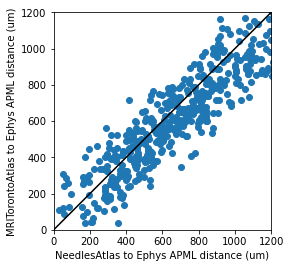

In [81]:
fig = plt.figure()
ax = fig.add_subplot()
plt.plot(na_dists,mri_dists,'o')
plt.plot([0,1200],[0,1200],'-k')
plt.xlim([0, 1200])
plt.ylim([0, 1200])
plt.xlabel('NeedlesAtlas to Ephys APML distance (um)')
plt.ylabel('MRITorontoAtlas to Ephys APML distance (um)')
ax.set_aspect('equal', adjustable='box')

In [82]:
np.median(na_dists)

752.4760926379181

In [83]:
np.median(mri_dists)

696.0461646552819

Text(0.5, 0, 'NeedlesAtlas to ephys distance minus MRITorontoAtlas to ephys distance (um)')

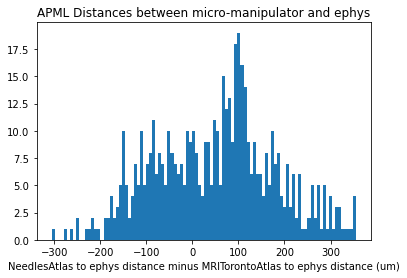

In [84]:
plt.hist(np.subtract(na_dists,mri_dists),bins=100)
plt.title('APML Distances between micro-manipulator and ephys')
plt.xlabel('NeedlesAtlas to ephys distance minus MRITorontoAtlas to ephys distance (um)')

# Display data using Urchin

In [11]:
import random
r = lambda: random.randint(0,255)
randHexColor = lambda : '#%02X%02X%02X' % (r(),r(),r())

In [22]:
colors = {}
labs = np.unique(traj_data['lab'].values)

for lab in labs:
    colors[lab] = randHexColor()

In [9]:
urn.setup()

(URN) connected to server
Login sent with ID: Dan


In [ ]:
# VIEW 1: Planned insertions
urn.clear()
count = 0

for i, row in traj_data.iterrows():
    probename = 'p'+str(i)
    urn.create_probes([probename])
    urn.set_probe_positions({probename:[row.ml, row.ap, row.dv]})
    urn.set_probe_colors({probename:'#808080'})
    urn.set_probe_angles({probename:[row.phi, row.theta, 0]})
    urn.set_probe_size({probename:[0.07,3.84,0.02]})

# # for some reason 'root' doesn't work?
urn.set_area_visibility({8:True})
urn.set_area_material({8:'transparent-unlit'})
urn.set_area_color({8:'#000000'})
urn.set_area_alpha({8:0.025})

In [56]:
urn.clear()

In [224]:
np.unique(traj_data['lab'].values)

array(['angelakilab', 'churchlandlab', 'churchlandlab_ucla', 'cortexlab',
       'danlab', 'hoferlab', 'mainenlab', 'mrsicflogellab', 'wittenlab',
       'zadorlab'], dtype=object)